### **Problema de clasificación de audio**

El problema trata de clasificar un audio intentando predecir a qué clase pertenece. Las distintas clases se dividen por la intención que tenga el usuario al hacer la consulta. En nuestro caso tenemos: `efectos_adversos` y `otros`.

In [7]:
# Activa inline plots
%matplotlib inline
import matplotlib
matplotlib.use('module://ipykernel.pylab.backend_inline')

import os
import numpy as np
import pandas as pd

from sklearn.model_selection  import train_test_split, GridSearchCV
from sklearn.preprocessing   import StandardScaler
from sklearn.ensemble        import RandomForestClassifier
from sklearn.pipeline        import Pipeline
from sklearn.metrics         import classification_report, confusion_matrix

from utils_audio import (
    preprocess_audio,
    extract_zcr,
    extract_centroid_rolloff,
    extract_mfcc
)

#### 1. **Generamos dataframe con audios y clases**

In [8]:
# 1) Carpeta base donde están tus audios organizados por subcarpeta = etiqueta
AUDIO_BASE = "data/outputs/6_audio"
# 2) Ruta donde guardar el CSV (si quieres)
OUT_CSV = "data/metadata.csv"

# 3) Recorre las subcarpetas y recoge filename + label
rows = []
for label in os.listdir(AUDIO_BASE):
    class_dir = os.path.join(AUDIO_BASE, label)
    if os.path.isdir(class_dir):
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(".wav"):
                rows.append({"filename": fname, "label": label})

# 4) Crea el DataFrame
df = pd.DataFrame(rows, columns=["filename", "label"])

# 5) (Opcional) Guárdalo en CSV
os.makedirs(os.path.dirname(OUT_CSV), exist_ok=True)
df.to_csv(OUT_CSV, index=False)

# 6) Comprueba resultado
print(f"DataFrame con {len(df)} filas y {len(df.columns)} columnas:")
print(df.head())

DataFrame con 20 filas y 2 columnas:
            filename             label
0  audio_8_angel.wav  efectos_adversos
1  audio_5_angel.wav  efectos_adversos
2  audio_3_angel.wav  efectos_adversos
3  audio_9_angel.wav  efectos_adversos
4  audio_4_angel.wav  efectos_adversos


#### 2. **Machine Learning**

In [9]:
# 1) Cargamos el DataFrame
df = pd.read_csv("data/metadata.csv")
AUDIO_BASE = "data/outputs/6_audio"


# 2) Función para vectorizar un clip (igual que antes)
def extract_clip_features(label: str, fname: str):
    clip_path = os.path.join(AUDIO_BASE, label, fname)
    y = preprocess_audio(clip_path, reduce_noise_flag=False)
    if y is None:
        print(f"Skipping (preproc failure): {clip_path}")
        return None

    zcr = extract_zcr(y, sr=16000)
    centroid, rolloff = extract_centroid_rolloff(y, sr=16000)
    mfcc = extract_mfcc(y, sr=16000, n_mfcc=13)

    feats = []
    for arr in (zcr, centroid, rolloff):
        feats += [arr.mean(), arr.std()]
    feats += list(mfcc.mean(axis=1)) + list(mfcc.std(axis=1))

    return np.array(feats)


# 3) Recorremos df para llenar X_list, y_list
X_list, y_list = [], []
for _, row in df.iterrows():
    feats = extract_clip_features(row["label"], row["filename"])
    if feats is not None:
        X_list.append(feats)
        y_list.append(row["label"])

# Ahora sí construimos X e y
X = np.vstack(X_list)  # (n_clips, n_features)
y = np.array(y_list)  # (n_clips,)

In [10]:
# 4) Split, pipeline, entrenamiento…
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe = Pipeline(
    [("scaler", StandardScaler()), ("clf", RandomForestClassifier(random_state=42))]
)

param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [None, 10, 20],
}

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)

y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores parámetros: {'clf__max_depth': None, 'clf__n_estimators': 100}
                  precision    recall  f1-score   support

efectos_adversos       0.67      1.00      0.80         2
           otros       1.00      0.50      0.67         2

        accuracy                           0.75         4
       macro avg       0.83      0.75      0.73         4
    weighted avg       0.83      0.75      0.73         4

Matriz de confusión:
 [[2 0]
 [1 1]]


##### **Evaluación del modelo**

In [11]:
print("Mejores parámetros:", grid.best_params_)

y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

Mejores parámetros: {'clf__max_depth': None, 'clf__n_estimators': 100}
                  precision    recall  f1-score   support

efectos_adversos       0.67      1.00      0.80         2
           otros       1.00      0.50      0.67         2

        accuracy                           0.75         4
       macro avg       0.83      0.75      0.73         4
    weighted avg       0.83      0.75      0.73         4

Matriz de confusión:
 [[2 0]
 [1 1]]


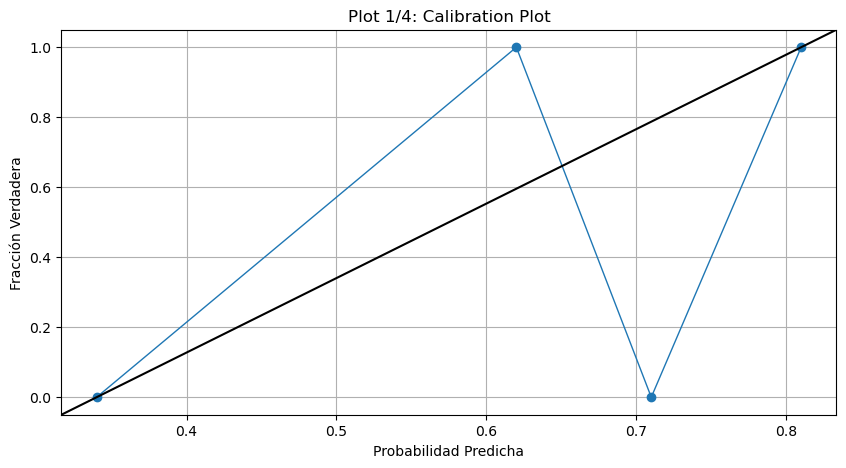

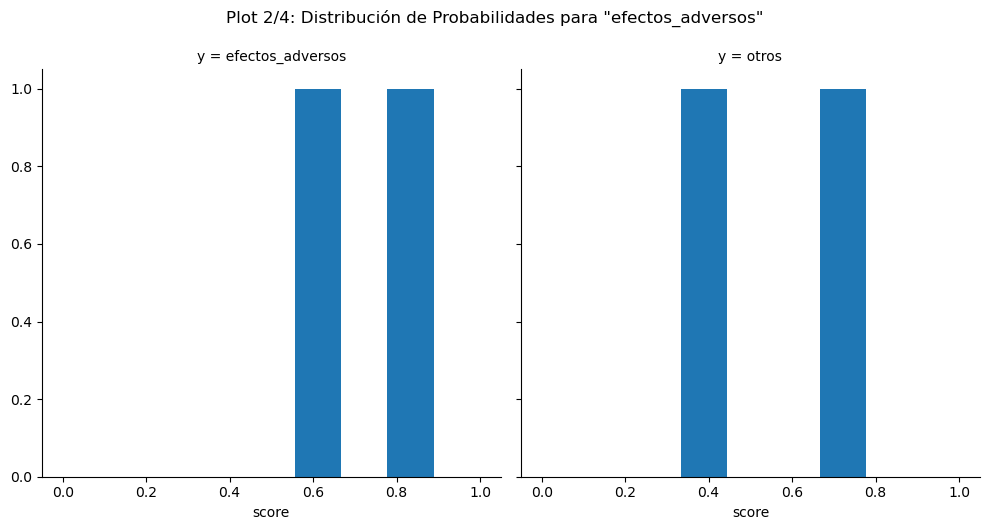

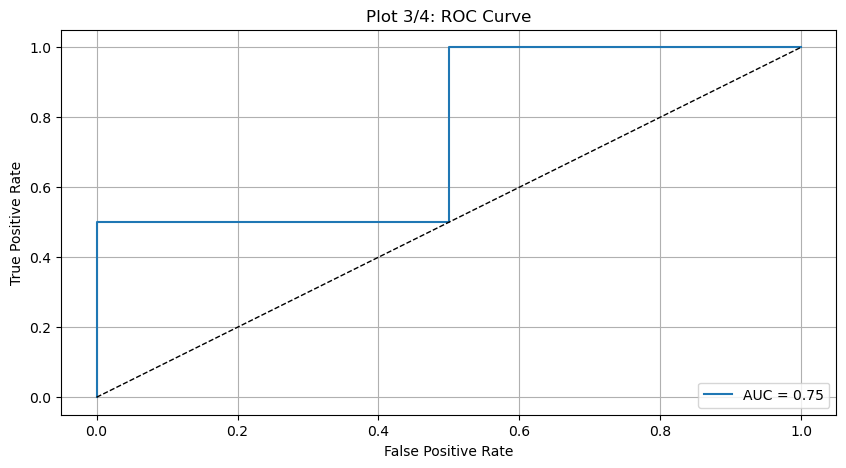

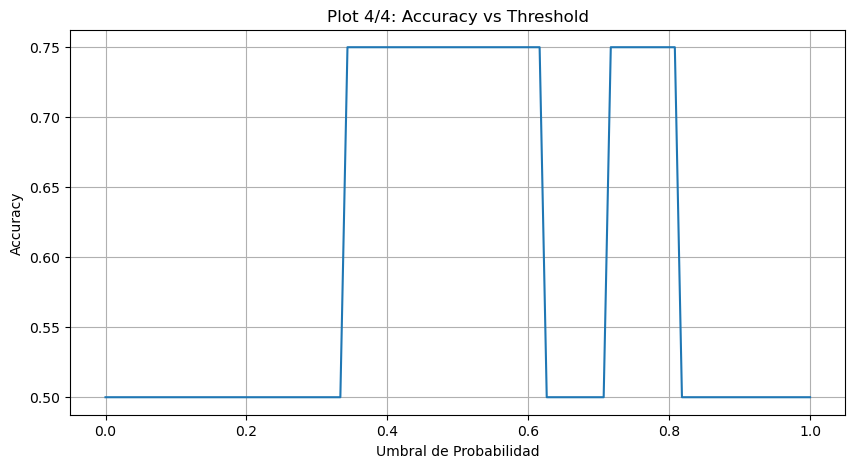

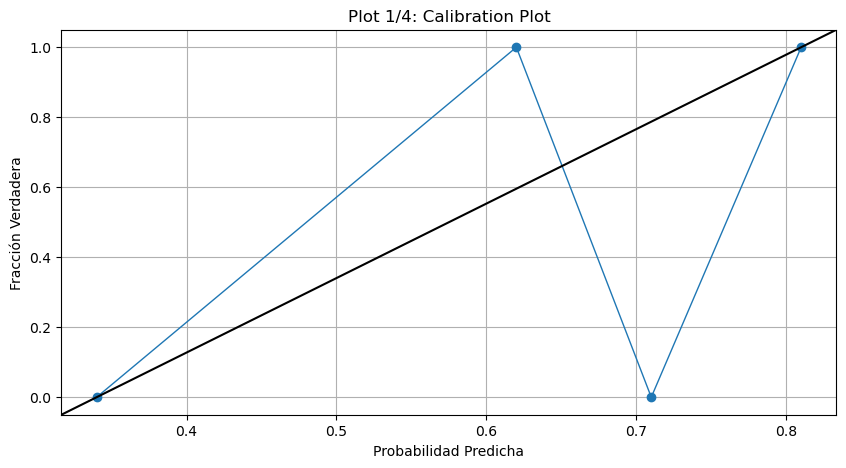

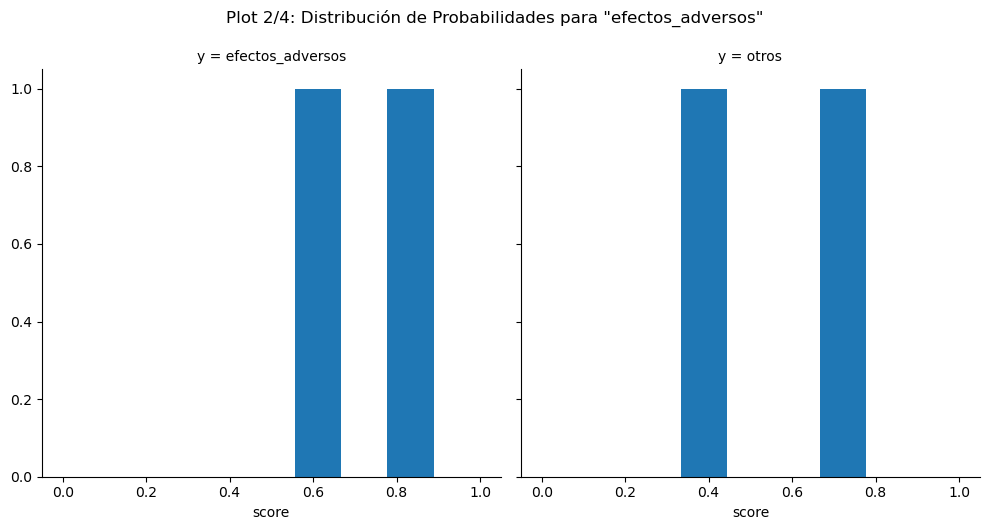

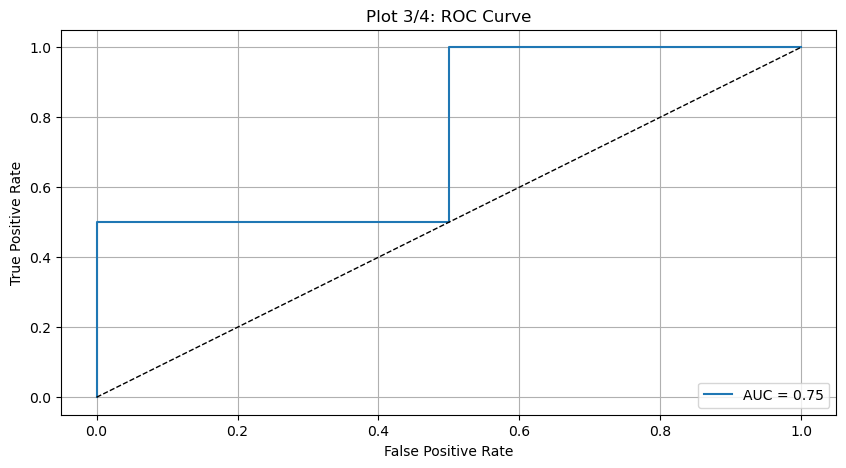

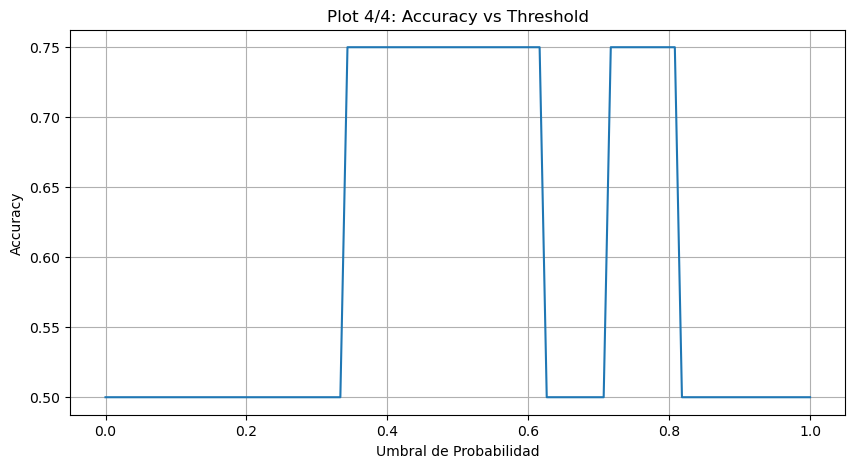

In [12]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.calibration import calibration_curve


def plotClassPerformance(
    y: pd.Series, prob_est: np.ndarray, selClass: str = None, figsize: tuple = (10, 5)
):
    """
    Crea 4 gráficas de rendimiento de clasificación para un problema binario:
      1) Calibration plot
      2) Histograma de probabilidades
      3) ROC Curve con AUC
      4) Accuracy vs umbral

    Args:
        y (pd.Series): valores verdaderos, dtype categórico o object.
        prob_est (np.ndarray): array (n_samples, 2) de probabilidades predichas.
        selClass (str, opcional): clase positiva. Si None, toma la segunda categoría.
        figsize (tuple): tamaño de las figuras.
    """
    # Determinar categorías
    try:
        categories = y.cat.categories
    except AttributeError:
        categories = np.unique(y)
    # Seleccionar clase positiva
    if selClass is None:
        selClass = categories[1] if len(categories) > 1 else categories[0]
        warnings.warn(f'Usando "{selClass}" como clase positiva', UserWarning)
    # Índice de la clase positiva
    pos_idx = list(categories).index(selClass)

    # Binarizar y extraer score
    y_true = (y == selClass).astype(int)
    scores = prob_est[:, pos_idx]

    # 1) Calibration plot
    frac_pos, mean_pred = calibration_curve(y_true, scores, n_bins=10)
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(mean_pred, frac_pos, marker="o", linewidth=1, label="Modelo")
    line = mlines.Line2D([0, 1], [0, 1], color="black", transform=ax.transAxes)
    ax.add_line(line)
    ax.set_title("Plot 1/4: Calibration Plot")
    ax.set_xlabel("Probabilidad Predicha")
    ax.set_ylabel("Fracción Verdadera")
    ax.grid(True)
    plt.show()

    # 2) Histograma de probabilidades
    df = pd.DataFrame({"y": y, "score": scores})
    g = sns.FacetGrid(
        df,
        col="y",
        sharex=True,
        height=figsize[1],
        aspect=figsize[0] / (2 * figsize[1]),
    )
    bins = np.linspace(0, 1, 10)
    g.map(plt.hist, "score", bins=bins)
    g.fig.suptitle(
        f'Plot 2/4: Distribución de Probabilidades para "{selClass}"', y=1.05
    )
    plt.show()

    # 3) ROC Curve
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    ax.plot([0, 1], [0, 1], "k--", linewidth=1)
    ax.set_title("Plot 3/4: ROC Curve")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)
    plt.show()

    # 4) Accuracy vs Threshold
    thresholds = np.linspace(0, 1, 100)
    accuracies = [accuracy_score(y_true, (scores >= t).astype(int)) for t in thresholds]
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(thresholds, accuracies)
    ax.set_title("Plot 4/4: Accuracy vs Threshold")
    ax.set_xlabel("Umbral de Probabilidad")
    ax.set_ylabel("Accuracy")
    ax.grid(True)
    plt.show()


# Ejemplo de uso (descomenta y ajusta):
y_test_series = pd.Series(y_test, name="label")
probas = grid.best_estimator_.predict_proba(X_test)
plotClassPerformance(y_test_series, probas, selClass="efectos_adversos")